#### **Librerías**

In [3]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import IPython
import gc
import torch.nn.functional as F
import torchaudio.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import torch.optim as optim
import torchaudio.transforms as T
import seaborn as sns
import copy
import xgboost as xgb
import collections
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture

from torch import nn, optim

from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchaudio.datasets import GTZAN
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchaudio.sox_effects import apply_effects_tensor

from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift, estimate_bandwidth, Birch, OPTICS
import scipy.cluster.hierarchy as sch


from tqdm.notebook import tqdm
from typing import Dict, Optional

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
samplerate = 22050

random_seed = 43992294

random_state = 43992294

torch.manual_seed(random_seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else
                    'mps' if torch.backends.mps.is_available() else
                    'cpu')

print(f"Dispositivo usado: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"MPS disponible: {torch.backends.mps.is_available()}")

Dispositivo usado: cuda:0
CUDA disponible: True
MPS disponible: False


#### **Funciones**

In [6]:
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Function to get encoded representations
def get_encoded_features(model, dataloader, device):
    features = []
    labels = []
    genres = []

    model.eval()

    with torch.no_grad():
        for wav, label, genre in tqdm(dataloader, desc="Extracting features"):
            wav = wav.to(device)
            # Get the encoded representation
            encoded = model.encoder(wav)
            # Average pooling across time dimension
            encoded = F.adaptive_avg_pool1d(encoded, 1).squeeze(-1)
            features.append(encoded.cpu().numpy())
            labels.append(label)
            genres.extend(genre)

    return np.vstack(features), np.concatenate(labels), genres

def train_autoencoder(autoencoder, train_dl, valid_dl, loss_function, optimizer, scheduler, device, num_epochs, checkpoint_path):
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        # Entrenamiento
        autoencoder.train()
        train_losses = []

        train_bar = tqdm(train_dl, desc=f'Epoch {epoch+1}/{num_epochs} - Training', leave=False)
        for wav, _, _ in train_bar:
            wav = wav.to(device)

            # Forward
            out = autoencoder(wav)
            loss = loss_function(out, wav)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # Actualizar barra de progreso
            train_bar.set_postfix({'Train Loss': f'{np.mean(train_losses):.4f}'})

            # Limpieza de memoria
            del wav, loss, out
            torch.cuda.empty_cache()
            gc.collect()

        # Validación
        autoencoder.eval()
        valid_losses = []

        valid_bar = tqdm(valid_dl, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', leave=False)
        with torch.no_grad():
            for wav, _, _ in valid_bar:
                wav = wav.to(device)

                # Forward
                out = autoencoder(wav)
                loss = loss_function(out, wav)

                valid_losses.append(loss.item())

                # Actualizar barra de progreso
                valid_bar.set_postfix({'Valid Loss': f'{np.mean(valid_losses):.4f}'})

                # Limpieza de memoria
                del wav, loss, out
                torch.cuda.empty_cache()
                gc.collect()

        # Calcular pérdidas promedio
        train_loss = np.mean(train_losses)
        valid_loss = np.mean(valid_losses)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')

        # Scheduler step
        scheduler.step(valid_loss)

        # Guardar el mejor modelo
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(autoencoder.state_dict(), checkpoint_path)
            print(f'--> Mejor modelo guardado con Valid Loss: {best_valid_loss:.4f}')

        # Limpieza de memoria al final de la época
        torch.cuda.empty_cache()
        gc.collect()

def evaluate_autoencoder(autoencoder, train_dl, checkpoint_path, samplerate, device, overlap = True):
    # Cargar el mejor modelo del autoencoder
    autoencoder.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    autoencoder.eval()

    # Seleccionar un batch de datos para reconstrucción
    wav, _, genre = next(iter(train_dl))
    wav = wav.to(device)  # Asegurarse de que esté en el dispositivo correcto

    # Reproducir el audio original
    print("Original Audio:")
    original_audio = wav[1].cpu().numpy()
    display(ipd.Audio(original_audio, rate=samplerate))

    # Reconstruir el audio
    with torch.no_grad():
        prediction = autoencoder(wav).cpu()

    # Reproducir el audio reconstruido
    print("Reconstructed Audio:")
    reconstructed_audio = prediction[1].cpu().numpy()
    display(ipd.Audio(reconstructed_audio, rate=samplerate))

    # Graficar las formas de onda
    if overlap:
        # Graficar superpuestas
        fig, ax = plt.subplots(figsize=(30, 5))
        ax.plot(original_audio[0, :], label="Original Waveform")
        ax.plot(reconstructed_audio[0, :], label="Reconstructed Waveform", alpha=0.5)
        ax.legend()
        plt.title('Waveform Comparison (Overlapped)')
        plt.show()
    else:
        # Graficar en subplots
        plt.figure(figsize=(15, 8))

        # Forma de onda original
        plt.subplot(2, 1, 1)
        plt.plot(wav[0, 0, :].cpu().numpy(), linewidth=1)
        plt.title('Original Waveform', fontsize=12)
        plt.ylabel('Amplitude')
        plt.grid(True, alpha=0.3)

        # Forma de onda reconstruida
        plt.subplot(2, 1, 2)
        plt.plot(prediction[0, 0, :].numpy(), linewidth=1, color='orange')
        plt.title('Reconstructed Waveform', fontsize=12)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.grid(True, alpha=0.3)

        # Ajustar el layout para evitar solapamiento
        plt.tight_layout()
        plt.show()

def train_and_evaluate_xgboost(autoencoder, checkpoint_path, param_grid, dataset, batch_size, device = device, random_state = random_state):

    # Cargar el modelo preentrenado del autoencoder
    autoencoder.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    autoencoder.eval()
    ae = os.path.basename(checkpoint_path).split('_')[-1].replace('.ckpt', '')

    # Crear un DataLoader sin shuffle para extracción de características
    feature_dl = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Extraer características
    print("Extrayendo características latentes...")
    features, labels, genres = get_encoded_features(autoencoder, feature_dl, device)
    print(f"Características extraídas: {features.shape}")

    # Normalizar las características
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # División en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled,
        labels,
        test_size=0.10,
        random_state=random_state,
        stratify=labels
    )

    # Definir el clasificador XGBoost
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(dataset.classes),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=random_state
    )

    # Configurar la búsqueda con validación cruzada reducida
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        cv=2,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    # Ejecutar la búsqueda
    print("Iniciando Grid Search para XGBoost...")
    grid_search.fit(X_train, y_train)

    # Resultados
    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor exactitud en entrenamiento: {grid_search.best_score_ * 100:.2f}%")

    # Entrenar el clasificador con los mejores parámetros
    best_xgb_clf = grid_search.best_estimator_

    # Evaluación en el conjunto de prueba
    y_pred_best = best_xgb_clf.predict(X_test)
    accuracy_best = accuracy_score(y_test, y_pred_best)
    print(f"Exactitud en Test (Mejor XGBoost): {accuracy_best * 100:.2f}%")

    # Reporte de clasificación
    print("Reporte de Clasificación (Mejor XGBoost):")
    print(classification_report(y_test, y_pred_best, target_names=dataset.classes))

    # Matriz de confusión
    conf_mat_best = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat_best, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión (Mejor XGBoost)')
    plt.show()

    # Guardar el mejor modelo
    best_classifier_path = f'/content/drive/MyDrive/TDVI_TP4/best_classifiers/best_XGBoostClassifier_{ae}.ckpt'
    os.makedirs(os.path.dirname(best_classifier_path), exist_ok=True)
    torch.save(best_xgb_clf, best_classifier_path)

    print('\nEntrenamiento completado!')
    print(f'Mejor pérdida de validación: {grid_search.best_score_:.4f}')
    print(f'El mejor clasificador se ha guardado en: {best_classifier_path}')

def train_music_genre_classifier(autoencoder, checkpoint_path, train_dl, valid_dl, dataset, device = device, num_epochs=30, lr=0.001):
    # Inicialización
    autoencoder.load_state_dict(torch.load(checkpoint_path))
    autoencoder.eval()
    ae = os.path.basename(checkpoint_path).split('_')[-1].replace('.ckpt', '')

    model = MusicGenreClassifier(autoencoder, num_genres=len(dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_valid_loss = float('inf')
    best_state_dict = None

    # Barra de progreso principal para las épocas
    epoch_bar = tqdm(range(num_epochs), desc='Epochs', position=0)

    for epoch in epoch_bar:
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0

        # Barra de progreso para training
        train_bar = tqdm(train_dl, desc='Training', position=1, leave=False)
        for wav, genre_idx, _ in train_bar:
            wav = wav.to(device)
            genre_idx = genre_idx.to(device)

            outputs = model(wav)
            loss = criterion(outputs, genre_idx)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            train_total += genre_idx.size(0)
            train_correct += (predicted == genre_idx).sum().item()

            # Actualizar barra de training
            train_acc = 100 * train_correct / train_total
            train_bar.set_description(f'Train Loss: {loss.item():.4f} | Acc: {train_acc:.2f}%')

            # Limpieza de memoria
            del wav, genre_idx, loss, outputs, predicted
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            elif torch.backends.mps.is_available():
                torch.mps.empty_cache()
            gc.collect()

        # Validation phase
        model.eval()
        valid_losses = []
        valid_correct = 0
        valid_total = 0
        all_preds = []
        all_labels = []

        valid_bar = tqdm(valid_dl, desc='Validation', position=1, leave=False)
        with torch.no_grad():
            for wav, genre_idx, _ in valid_bar:
                wav = wav.to(device)
                genre_idx = genre_idx.to(device)

                outputs = model(wav)
                loss = criterion(outputs, genre_idx)

                valid_losses.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                valid_total += genre_idx.size(0)
                valid_correct += (predicted == genre_idx).sum().item()

                # Guardar predicciones y etiquetas para métricas posteriores
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(genre_idx.cpu().numpy())

                valid_acc = 100 * valid_correct / valid_total
                valid_bar.set_description(f'Valid Loss: {loss.item():.4f} | Acc: {valid_acc:.2f}%')

                # Limpieza de memoria
                del wav, genre_idx, loss, outputs, predicted
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                elif torch.backends.mps.is_available():
                    torch.mps.empty_cache()
                gc.collect()

        # Calcular métricas finales de la época
        train_loss = np.mean(train_losses)
        train_acc = 100 * train_correct / train_total
        valid_loss = np.mean(valid_losses)
        valid_acc = 100 * valid_correct / valid_total

        epoch_bar.set_description(
            f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {valid_loss:.4f} | Val Acc: {valid_acc:.2f}%'
        )

        # Actualizar learning rate y guardar mejor modelo
        scheduler.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_state_dict = model.state_dict().copy()

    # Evaluación final en el conjunto de validación
    print("\nEvaluación Final:")
    print(f"Pérdida de validación más baja: {best_valid_loss:.4f}")

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Exactitud en Validación: {accuracy * 100:.2f}%")

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Matriz de confusión
    conf_mat = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    # Guardar mejor modelo
    best_classifier_path = f'/content/drive/MyDrive/TDVI_TP4/best_classifiers/best_classifier_{ae}.ckpt'
    torch.save(best_state_dict, best_classifier_path)
    print(f'Modelo guardado en: {best_classifier_path}')


def plot_clustering_results(features_2d, labels, clusters, title, cmap='tab10'):
    """
    Genera un scatter plot para los resultados de clustering.

    Args:
        features_2d (ndarray): Características reducidas a 2D (por ejemplo, PCA).
        labels (ndarray): Etiquetas verdaderas de los datos.
        clusters (ndarray): Etiquetas de clusters asignadas por el algoritmo de clustering.
        title (str): Título del gráfico.
        cmap (str): Mapa de colores para los clusters.
    """
    plt.figure(figsize=(16, 10))

    scatter = plt.scatter(
        features_2d[:, 0],
        features_2d[:, 1],
        c=labels,
        cmap=cmap,
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5
    )

    cbar = plt.colorbar(scatter, ticks=range(len(np.unique(clusters))))
    cbar.set_label('Cluster', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticklabels(np.unique(clusters))

    plt.title(title, fontsize=16)
    plt.xlabel('Primera Componente Principal', fontsize=14)
    plt.ylabel('Segunda Componente Principal', fontsize=14)

    # Ajustar el layout para que todo encaje bien
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


#### **Clases**

In [7]:
class MusicDataset(Dataset):
    def __init__(self, root = '/content/drive/MyDrive/TDVI_TP4/genres_5sec'):
        super().__init__()
        self.root = root
        self.files =[]
        classes = self.get_classes(self.root)
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx, genre

    def get_classes(self, root):
        list_files = os.listdir(root)
        classes = []
        for file in list_files:
            name = '{}/{}'.format(root, file)
            if os.path.isdir(name):
                classes.append(file)
        return classes

# [(W−K+2P)/S]+1, where W is the input size, K is the kernel size, P is the padding, and S is the stride.
class CELAutoencoderLR(nn.Module):
    def __init__(self):
        super(CELAutoencoderLR, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 110250 (formula: [(110250-9+2*4)/1]+1 = [(110250-9+8)/1]+1 = [110250/1]+1 = 110250+1 = 110251) -> 16x110250
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 110250 -> Output size = 110249 (formula: [(110250-2)/2]+1 = [(110248)/2]+1 = 110248/2+1 = 55124+1 = 55125) -> 16x55125

            nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 32x55125
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 64x55125
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 55125 -> Output size = 27562 -> 64x27562

            nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 128x27562
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 256x27562
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 27562 -> Output size = 13781 -> 256x13781

            nn.Conv1d(256, 512, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 13781 -> 512x13781
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 13781 -> Output size = 6890 -> 512x6890
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 6890 -> Output size = 13781 -> 256x13781
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Upsample(size=27562),  # Tamaño específico en lugar de scale_factor

            nn.ConvTranspose1d(256, 128, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 27562 -> 128x27562
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 55125 -> 64x27562
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Upsample(size=55125),  # Tamaño específico

            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 110250 -> 32x55125
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 110250 -> 16x55125
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Upsample(size=110250),  # Tamaño específico para match exacto

            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 220500 -> 1x110250
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        if decoded.size(2) != x.size(2):
            decoded = F.interpolate(decoded, size=x.size(2), mode='linear')
        return decoded

# [(W−K+2P)/S]+1, where W is the input size, K is the kernel size, P is the padding, and S is the stride.
class CELAutoencoderSiLU(nn.Module):
    def __init__(self):
        super(CELAutoencoderSiLU, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 110250 (formula: [(110250-9+2*4)/1]+1 = [(110250-9+8)/1]+1 = [110250/1]+1 = 110250+1 = 110251) -> 16x110250
            nn.BatchNorm1d(16),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 110250 -> Output size = 110249 (formula: [(110250-2)/2]+1 = [(110248)/2]+1 = 110248/2+1 = 55124+1 = 55125) -> 16x55125

            nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 32x55125
            nn.BatchNorm1d(32),
            nn.SiLU(),

            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 64x55125
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 55125 -> Output size = 27562 -> 64x27562

            nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 128x27562
            nn.BatchNorm1d(128),
            nn.SiLU(),

            nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 256x27562
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 27562 -> Output size = 13781 -> 256x13781

            nn.Conv1d(256, 512, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 13781 -> 512x13781
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 13781 -> Output size = 6890 -> 512x6890
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 6890 -> Output size = 13781 -> 256x13781
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Upsample(size=27562),  # Tamaño específico en lugar de scale_factor

            nn.ConvTranspose1d(256, 128, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 27562 -> 128x27562
            nn.BatchNorm1d(128),
            nn.SiLU(),

            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 55125 -> 64x27562
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Upsample(size=55125),  # Tamaño específico

            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 110250 -> 32x55125
            nn.BatchNorm1d(32),
            nn.SiLU(),

            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 110250 -> 16x55125
            nn.BatchNorm1d(16),
            nn.SiLU(),
            nn.Upsample(size=110250),  # Tamaño específico para match exacto

            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 220500 -> 1x110250
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        if decoded.size(2) != x.size(2):
            decoded = F.interpolate(decoded, size=x.size(2), mode='linear')
        return decoded

class CELAutoencoder2(nn.Module):
    def __init__(self):
        super(CELAutoencoder2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=9, stride=1, padding=4), # Input: 110250 -> Output: 110250
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 110250 -> Output size = 55125 -> 64x55125

            nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=4), # Input size = 55125 -> Output size = 55125 -> 128x55125
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 55125 -> Output size = 27562 -> 128x27562

            nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 256x27562
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 27562 -> Output size = 13781 -> 256x13781

            nn.Conv1d(256, 512, kernel_size=9, stride=1, padding=4), # Input size = 13781 -> Output size = 13781 -> 512x13781
            nn.BatchNorm1d(512),
            nn.SiLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 13781 -> Output size = 27562 -> 256x27562
            nn.BatchNorm1d(256),
            nn.SiLU(),

            nn.ConvTranspose1d(256, 128, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 27562 -> Output size = 55125 -> 128x55125
            nn.BatchNorm1d(128),
            nn.SiLU(),

            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 55125 -> Output size = 110250 -> 64x110250
            nn.BatchNorm1d(64),
            nn.SiLU(),

            nn.ConvTranspose1d(64, 1, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 220500 -> 1x110250
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        if decoded.size(2) != x.size(2):
            decoded = F.interpolate(decoded, size=x.size(2), mode='linear')
        return decoded


class CELAutoencoder3(nn.Module):
    def __init__(self):
        super(CELAutoencoder3, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4), # Input size = 110250 -> Output size = 110250 (formula: [(110250-9+2*4)/1]+1 = [(110250-9+8)/1]+1 = [110250/1]+1 = 110250+1 = 110251) -> 16x110250
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4), # Input size = 110250 -> Output size = 27562 -> 16x27562

            nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4), # Input size = 27562 -> Output size = 27562 -> 32x27562
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4), # Input size = 27562 -> Output size = 6890 -> 32x6890

            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4), # Input size = 6890 -> Output size = 6890 -> 64x6890
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4), # Input size = 6890 -> Output size = 1722 -> 64x1722

            nn.Conv1d(64, 256, kernel_size=9, stride=1, padding=4), # Input size = 1722 -> Output size = 1722 -> 256x1722
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Input size = 1722 -> Output size = 861 -> 256x861
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 861 -> Output size = 1722 -> 128x1722
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 1722 -> Output size = 3444 -> 64x3444
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 3444 -> Output size = 6888 -> 32x6888
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 6888 -> Output size = 13776 -> 16x13776
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(16, 8, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 13776 -> Output size = 27552 -> 8x27552
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(8, 4, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 27552 -> Output size = 55104 -> 4x55104
            nn.BatchNorm1d(4),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(4, 1, kernel_size=9, stride=2, padding=4, output_padding=1), # Input size = 55104 -> Output size = 110208 -> 1x110208
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        if decoded.size(2) != x.size(2):
            decoded = F.interpolate(decoded, size=x.size(2), mode='linear')
        return decoded

class MusicGenreClassifier(nn.Module):
    def __init__(self, autoencoder, num_genres=10):
        super(MusicGenreClassifier, self).__init__()

        self.encoder = autoencoder.encoder

        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Linear(128, num_genres)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output




In [8]:
dataset = MusicDataset()

#### **Visualización**

In [ ]:
waveform, label, genre = dataset[1]
print("shape of waveform {}, sample rate with {}, label is {} ({}) ".format(waveform.size(),samplerate,label,genre))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 0 (jazz) 


shape of spectogram torch.Size([1, 201, 552])


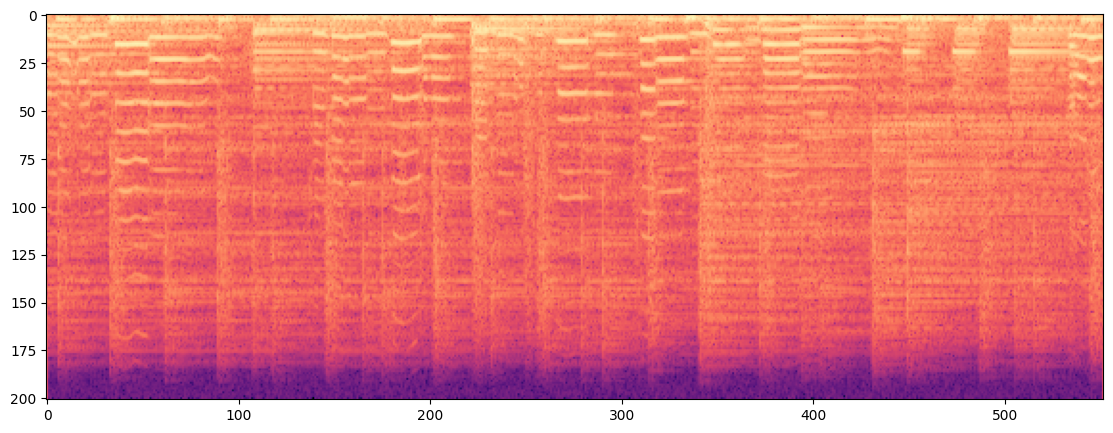

In [ ]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[0.0665, 0.1647, 0.2319,  ..., 0.1070, 0.1163, 0.1717]])



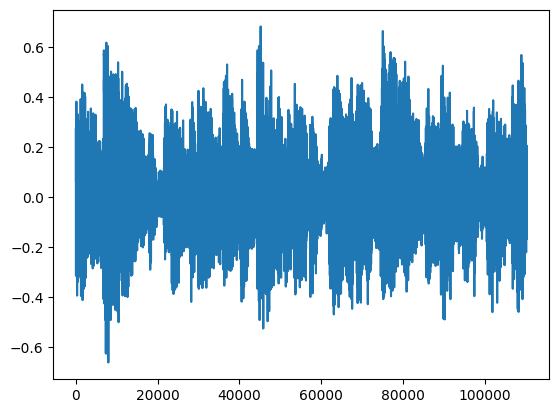

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [ ]:
IPython.display.Audio(waveform,rate=samplerate)

#### **Experimentos**


In [9]:
batch_size = 20
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

if torch.cuda.is_available():
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
    valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
    test_dl = DataLoader(test_ds, 1, num_workers=1, pin_memory=True)
else:
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size*2)
    test_dl = DataLoader(test_ds,1)

#### **CELAutoencoderLR**

In [49]:
# Autoencoder
autoencoder = CELAutoencoderSiLU().to(device)

# Parametros
parameters = [p for p in autoencoder.parameters() if p.requires_grad]

# Optimizador
optimizer = optim.Adam(parameters, lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Funcion de loss
loss_function = nn.MSELoss()

# Epochs
num_epochs = 15

# Guardado en
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_LeakyRelu.ckpt'

del parameters
torch.cuda.empty_cache()
gc.collect()

# Entrenamos
train_autoencoder(autoencoder, train_dl, valid_dl, loss_function, optimizer, scheduler, device, num_epochs, checkpoint_path)

Epoch 1/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.0233 | Valid Loss: 0.0118
--> Mejor modelo guardado con Valid Loss: 0.0118


Epoch 2/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.0088 | Valid Loss: 0.0100
--> Mejor modelo guardado con Valid Loss: 0.0100


Epoch 3/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.0077 | Valid Loss: 0.0082
--> Mejor modelo guardado con Valid Loss: 0.0082


Epoch 4/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.0067 | Valid Loss: 0.0070
--> Mejor modelo guardado con Valid Loss: 0.0070


Epoch 5/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.0068 | Valid Loss: 0.0089


Epoch 6/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.0062 | Valid Loss: 0.0091


Epoch 7/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.0062 | Valid Loss: 0.0066
--> Mejor modelo guardado con Valid Loss: 0.0066


Epoch 8/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.0060 | Valid Loss: 0.0060
--> Mejor modelo guardado con Valid Loss: 0.0060


Epoch 9/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.0055 | Valid Loss: 0.0057
--> Mejor modelo guardado con Valid Loss: 0.0057


Epoch 10/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.0053 | Valid Loss: 0.0058


Epoch 11/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.0055 | Valid Loss: 0.0058


Epoch 12/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.0053 | Valid Loss: 0.0060


Epoch 13/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.0053 | Valid Loss: 0.0062


Epoch 14/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.0052 | Valid Loss: 0.0055
--> Mejor modelo guardado con Valid Loss: 0.0055


Epoch 15/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.0049 | Valid Loss: 0.0054
--> Mejor modelo guardado con Valid Loss: 0.0054


Original Audio:


Reconstructed Audio:


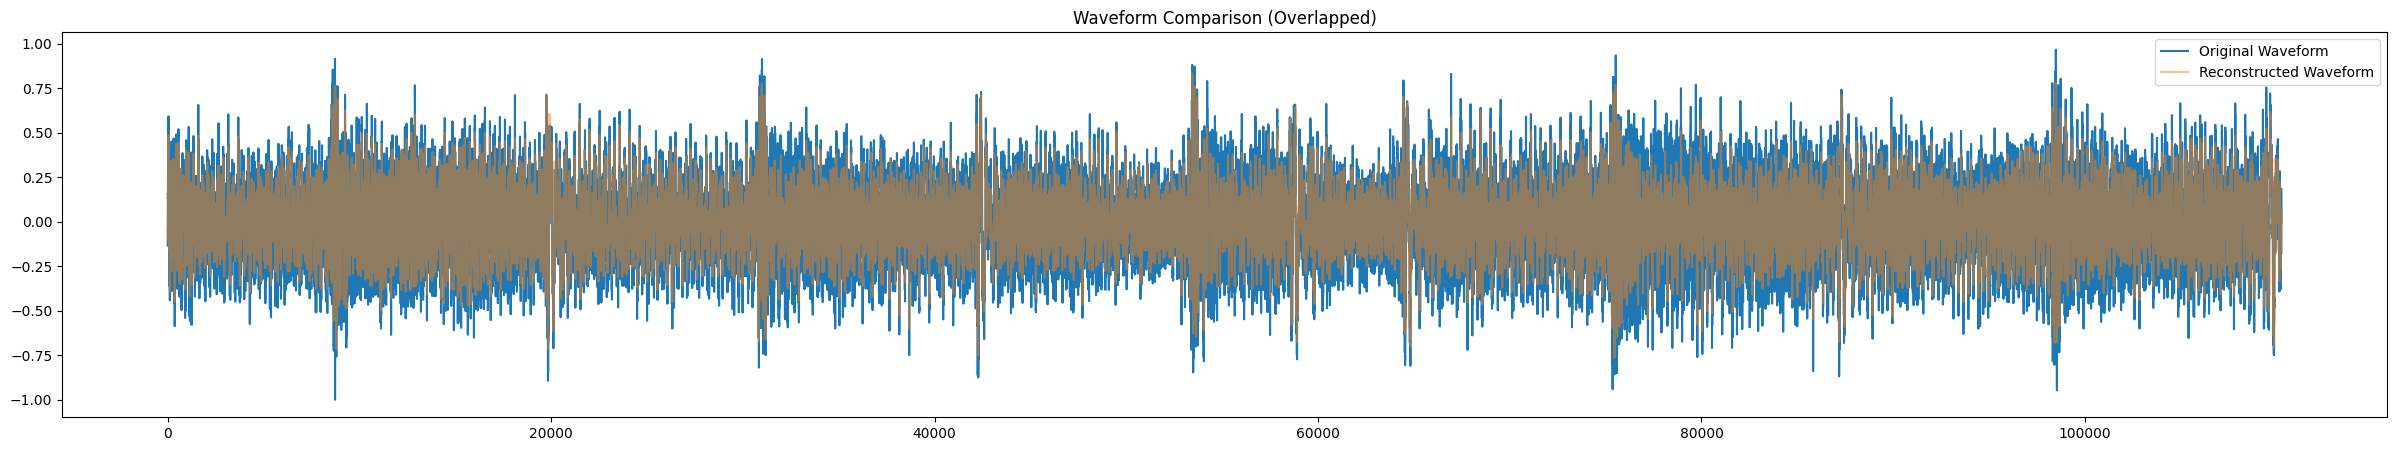

In [50]:
evaluate_autoencoder(autoencoder, train_dl, checkpoint_path, samplerate, device)

#### **CELAutoencoderSiLU**

In [51]:
# Autoencoder
autoencoder = CELAutoencoderSiLU().to(device)

# Parametros
parameters = [p for p in autoencoder.parameters() if p.requires_grad]

# Optimizador
optimizer = optim.Adam(parameters, lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Funcion de loss
loss_function = nn.MSELoss()

# Epochs
num_epochs = 10

# Guardado en
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_SiLU.ckpt'

del parameters
torch.cuda.empty_cache()
gc.collect()

# Entrenamos
train_autoencoder(autoencoder, train_dl, valid_dl, loss_function, optimizer, scheduler, device, num_epochs, checkpoint_path)


Epoch 1/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.0343 | Valid Loss: 0.0120
--> Mejor modelo guardado con Valid Loss: 0.0120


Epoch 2/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.0103 | Valid Loss: 0.0119
--> Mejor modelo guardado con Valid Loss: 0.0119


Epoch 3/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.0088 | Valid Loss: 0.0098
--> Mejor modelo guardado con Valid Loss: 0.0098


Epoch 4/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.0076 | Valid Loss: 0.0102


Epoch 5/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.0070 | Valid Loss: 0.0073
--> Mejor modelo guardado con Valid Loss: 0.0073


Epoch 6/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.0068 | Valid Loss: 0.0071
--> Mejor modelo guardado con Valid Loss: 0.0071


Epoch 7/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.0062 | Valid Loss: 0.0066
--> Mejor modelo guardado con Valid Loss: 0.0066


Epoch 8/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.0060 | Valid Loss: 0.0106


Epoch 9/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.0057 | Valid Loss: 0.0059
--> Mejor modelo guardado con Valid Loss: 0.0059


Epoch 10/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.0058 | Valid Loss: 0.0067


Epoch 11/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.0057 | Valid Loss: 0.0057
--> Mejor modelo guardado con Valid Loss: 0.0057


Epoch 12/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.0054 | Valid Loss: 0.0056
--> Mejor modelo guardado con Valid Loss: 0.0056


Epoch 13/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.0057 | Valid Loss: 0.0059


Epoch 14/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.0055 | Valid Loss: 0.0059


Epoch 15/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.0056 | Valid Loss: 0.0066


Original Audio:


Reconstructed Audio:


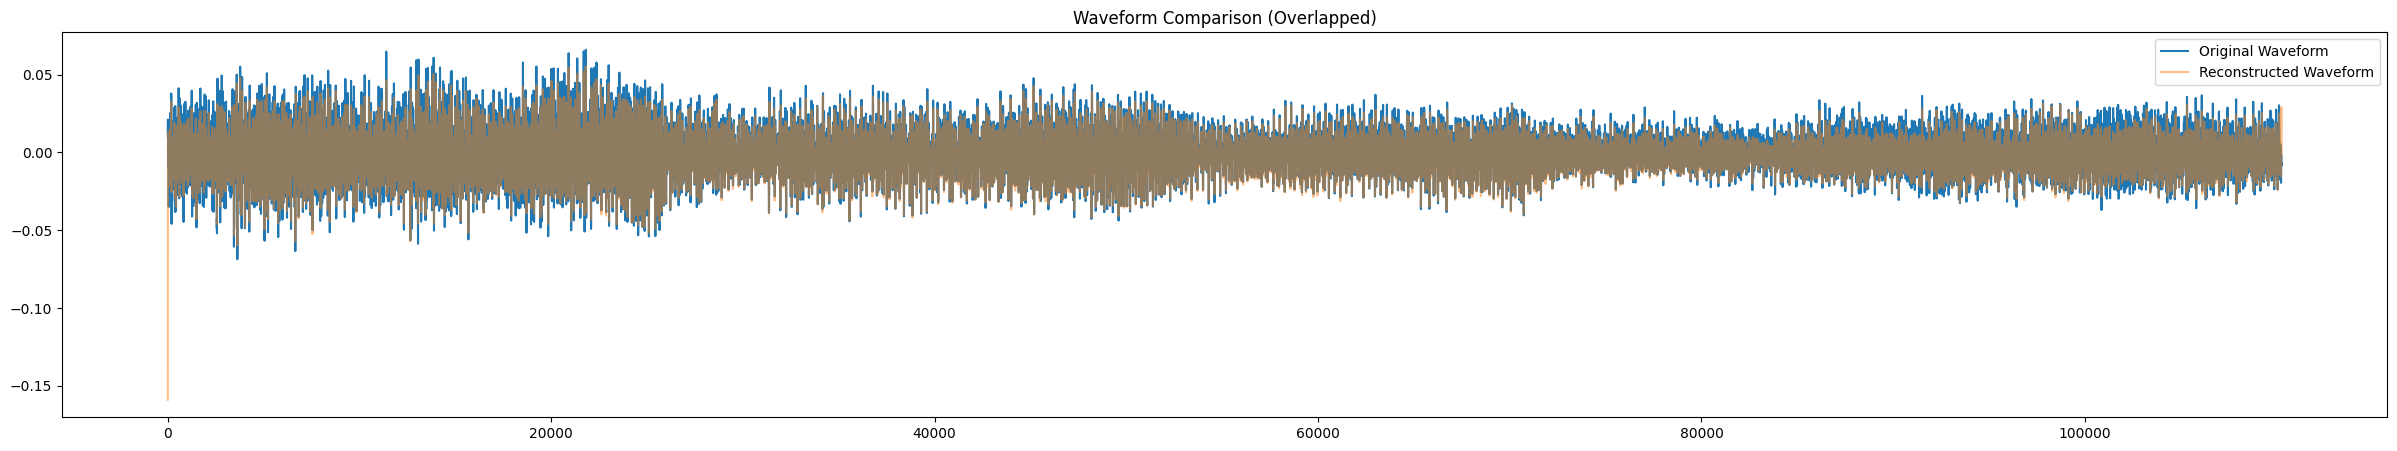

In [52]:
evaluate_autoencoder(autoencoder, train_dl, checkpoint_path, samplerate, device)

#### **CELAutoencoder2**

In [53]:
# Autoencoder
autoencoder = CELAutoencoder2().to(device)

# Parametros
parameters = [p for p in autoencoder.parameters() if p.requires_grad]

# Optimizador
optimizer = optim.Adam(parameters, lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Funcion de loss
loss_function = nn.MSELoss()

# Epochs
num_epochs = 10

# Guardado en
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_CEL2.ckpt'

del parameters
torch.cuda.empty_cache()
gc.collect()

# Entrenamos
train_autoencoder(autoencoder, train_dl, valid_dl, loss_function, optimizer, scheduler, device, num_epochs, checkpoint_path)

Epoch 1/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2228 | Valid Loss: 0.0350
--> Mejor modelo guardado con Valid Loss: 0.0350


Epoch 2/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.0251 | Valid Loss: 0.0234
--> Mejor modelo guardado con Valid Loss: 0.0234


Epoch 3/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.0137 | Valid Loss: 0.0185
--> Mejor modelo guardado con Valid Loss: 0.0185


Epoch 4/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.0091 | Valid Loss: 0.0124
--> Mejor modelo guardado con Valid Loss: 0.0124


Epoch 5/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.0092 | Valid Loss: 0.0135


Epoch 6/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.0065 | Valid Loss: 0.0055
--> Mejor modelo guardado con Valid Loss: 0.0055


Epoch 7/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.0056 | Valid Loss: 0.0068


Epoch 8/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.0059 | Valid Loss: 0.0074


Epoch 9/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.0068 | Valid Loss: 0.0056


Epoch 10/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.0060 | Valid Loss: 0.0170


Epoch 11/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.0064 | Valid Loss: 0.0056


Epoch 12/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.0046 | Valid Loss: 0.0042
--> Mejor modelo guardado con Valid Loss: 0.0042


Epoch 13/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.0050 | Valid Loss: 0.0049


Epoch 14/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.0038 | Valid Loss: 0.0037
--> Mejor modelo guardado con Valid Loss: 0.0037


Epoch 15/15 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/15 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.0034 | Valid Loss: 0.0039


Original Audio:


Reconstructed Audio:


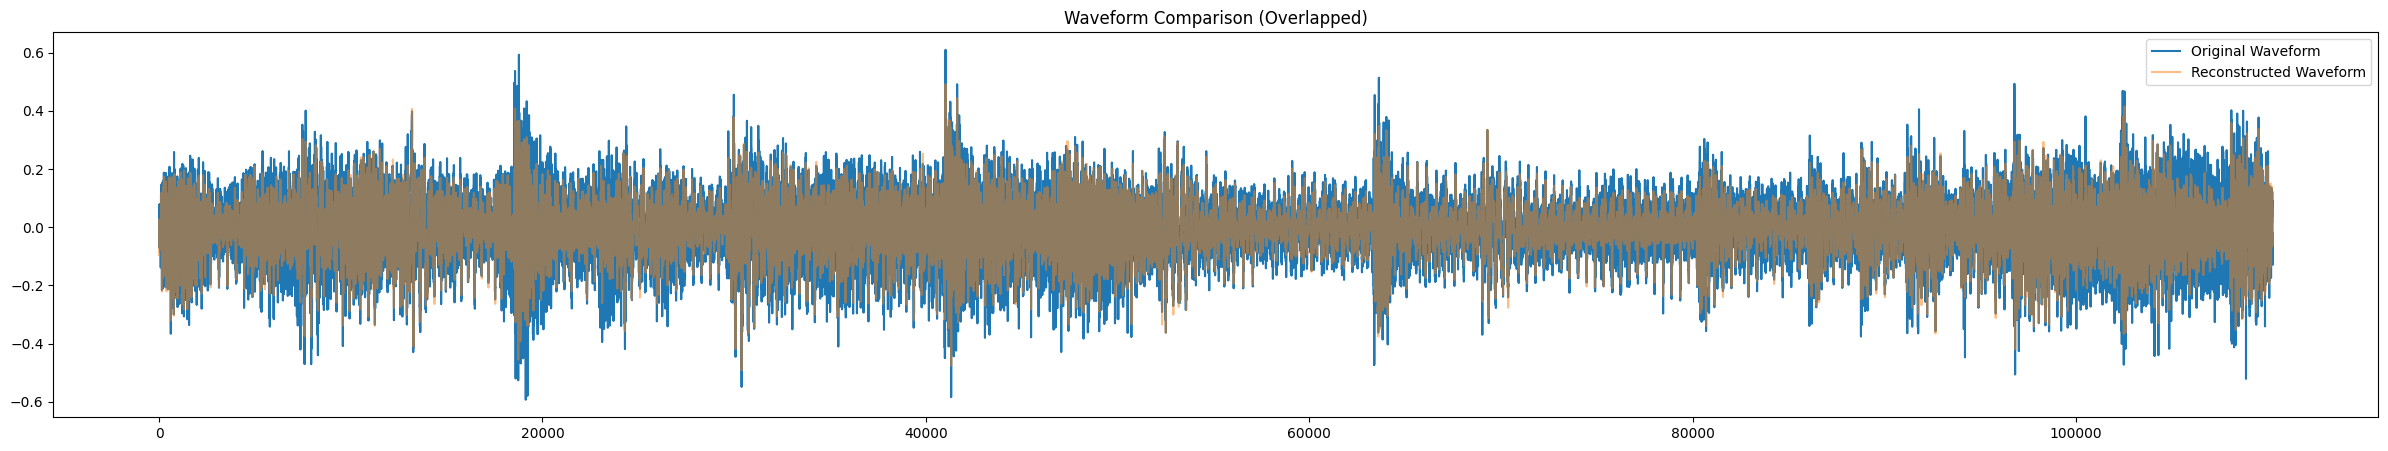

In [54]:
evaluate_autoencoder(autoencoder, train_dl, checkpoint_path, samplerate, device)

#### **CELAutoencoder3**

In [55]:
# Autoencoder
autoencoder = CELAutoencoder3().to(device)

# Parametros
parameters = [p for p in autoencoder.parameters() if p.requires_grad]

# Optimizador
optimizer = optim.Adam(parameters, lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Funcion de loss
loss_function = nn.MSELoss()

# Epochs
num_epochs = 15

# Guardado en
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_CEL3.ckpt'

del parameters
torch.cuda.empty_cache()
gc.collect()

# Entrenamos
train_autoencoder(autoencoder, train_dl, valid_dl, loss_function, optimizer, scheduler, device, num_epochs, checkpoint_path)

Epoch 1/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.0300 | Valid Loss: 0.0274
--> Mejor modelo guardado con Valid Loss: 0.0274


Epoch 2/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.0226 | Valid Loss: 0.0270
--> Mejor modelo guardado con Valid Loss: 0.0270


Epoch 3/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.0223 | Valid Loss: 0.0268
--> Mejor modelo guardado con Valid Loss: 0.0268


Epoch 4/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.0194 | Valid Loss: 0.0193
--> Mejor modelo guardado con Valid Loss: 0.0193


Epoch 5/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0149 | Valid Loss: 0.0172
--> Mejor modelo guardado con Valid Loss: 0.0172


Epoch 6/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0142 | Valid Loss: 0.0155
--> Mejor modelo guardado con Valid Loss: 0.0155


Epoch 7/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0132 | Valid Loss: 0.0152
--> Mejor modelo guardado con Valid Loss: 0.0152


Epoch 8/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0129 | Valid Loss: 0.0146
--> Mejor modelo guardado con Valid Loss: 0.0146


Epoch 9/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0125 | Valid Loss: 0.0145
--> Mejor modelo guardado con Valid Loss: 0.0145


Epoch 10/10 - Training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0122 | Valid Loss: 0.0139
--> Mejor modelo guardado con Valid Loss: 0.0139


Original Audio:


Reconstructed Audio:


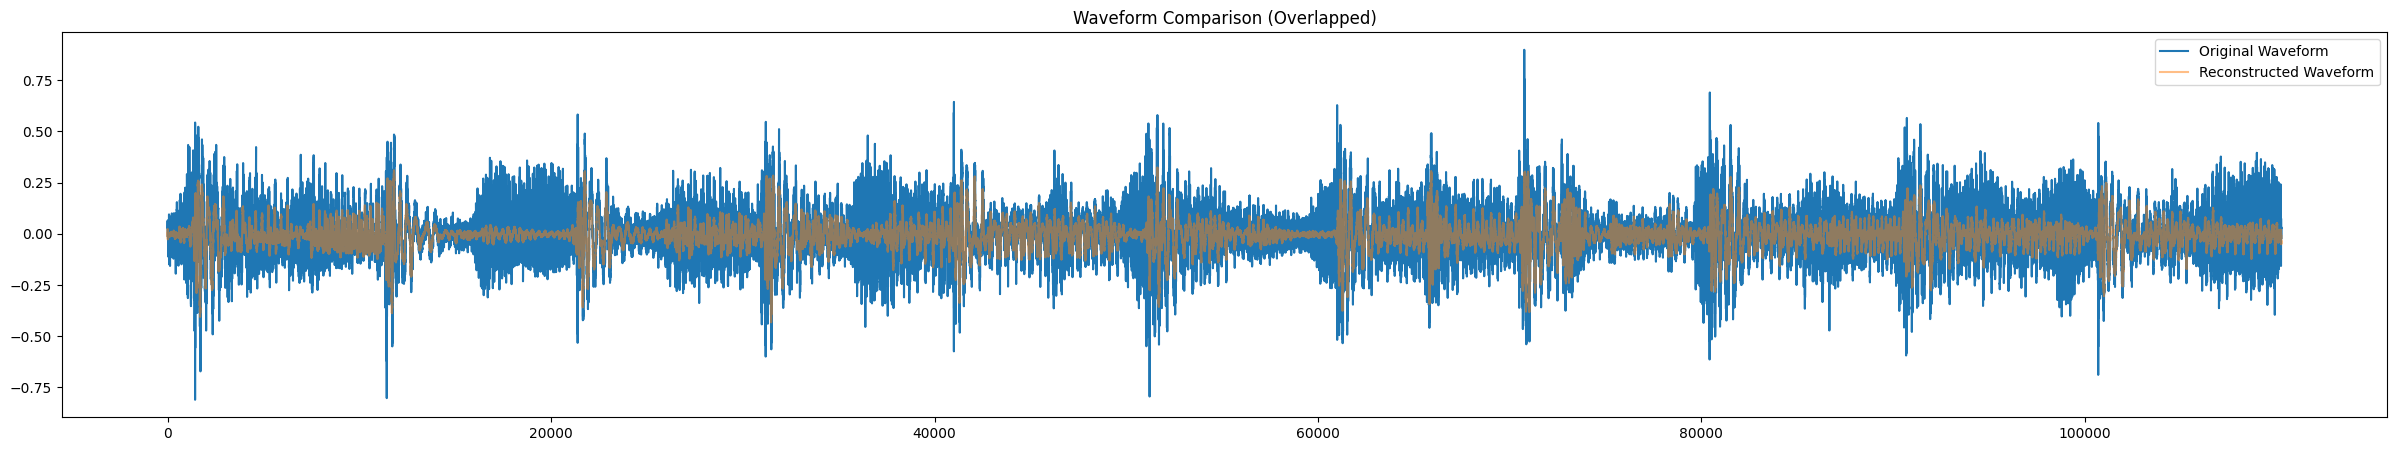

In [56]:
evaluate_autoencoder(autoencoder, train_dl, checkpoint_path, samplerate, device)

#### **Modelos de clasificación**

##### **XGBoost**

Extrayendo características latentes...


Extracting features:   0%|          | 0/50 [00:00<?, ?it/s]

Características extraídas: (990, 512)
Iniciando Grid Search para XGBoost...
Fitting 2 folds for each of 16 candidates, totalling 32 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:40:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.6}
Mejor exactitud en entrenamiento: 43.88%
Exactitud en Test (Mejor XGBoost): 46.46%
Reporte de Clasificación (Mejor XGBoost):
              precision    recall  f1-score   support

         pop       0.56      0.50      0.53        10
        jazz       0.60      0.60      0.60        10
       blues       0.29      0.50      0.37        10
   classical       0.58      0.70      0.64        10
     country       0.20      0.10      0.13        10
      hiphop       0.40      0.22      0.29         9
       metal       0.57      0.80      0.67        10
       disco       0.56      0.50      0.53        10
        rock       0.30      0.30      0.30        10
      reggae       0.50      0.40      0.44        10

    accuracy                           0.46        99
   macro avg       0.46      0.46      0.45        99
weighted avg       0.46      0.46      0.45        99



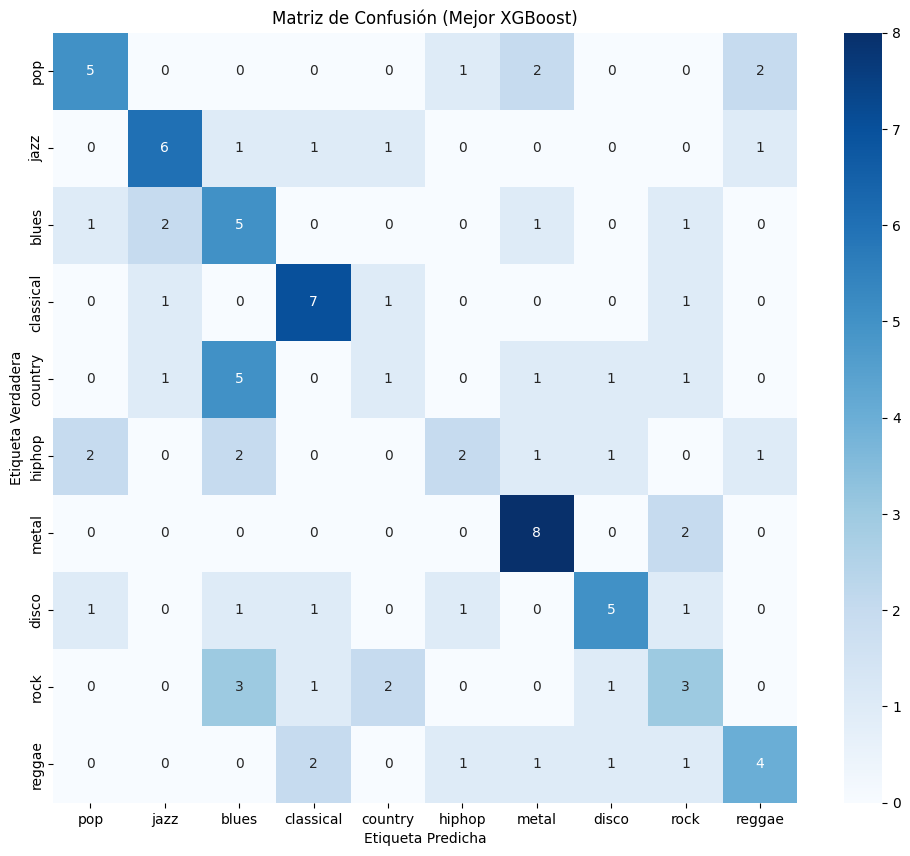


Entrenamiento completado!
Mejor pérdida de validación: 0.4388
El mejor clasificador se ha guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_XGBoostClassifier_LeakyRelu.ckpt


In [58]:
# Cargar el mejor modelo del autoencoder
autoencoder = CELAutoencoderLR().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_LeakyRelu.ckpt'
# Definir el espacio de hiperparámetros reducido
param_grid = {
    'max_depth': [7, 9],
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8]
}
train_and_evaluate_xgboost(autoencoder, checkpoint_path, param_grid, dataset, batch_size)

Extrayendo características latentes...


Extracting features:   0%|          | 0/50 [00:00<?, ?it/s]

Características extraídas: (990, 512)
Iniciando Grid Search para XGBoost...
Fitting 2 folds for each of 16 candidates, totalling 32 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:08:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Mejor exactitud en entrenamiento: 44.00%
Exactitud en Test (Mejor XGBoost): 47.47%
Reporte de Clasificación (Mejor XGBoost):
              precision    recall  f1-score   support

         pop       0.80      0.40      0.53        10
        jazz       0.50      0.60      0.55        10
       blues       0.32      0.60      0.41        10
   classical       0.58      0.70      0.64        10
     country       0.11      0.10      0.11        10
      hiphop       0.40      0.22      0.29         9
       metal       0.67      0.80      0.73        10
       disco       0.50      0.60      0.55        10
        rock       0.50      0.20      0.29        10
      reggae       0.56      0.50      0.53        10

    accuracy                           0.47        99
   macro avg       0.49      0.47      0.46        99
weighted avg       0.49      0.47      0.46        99



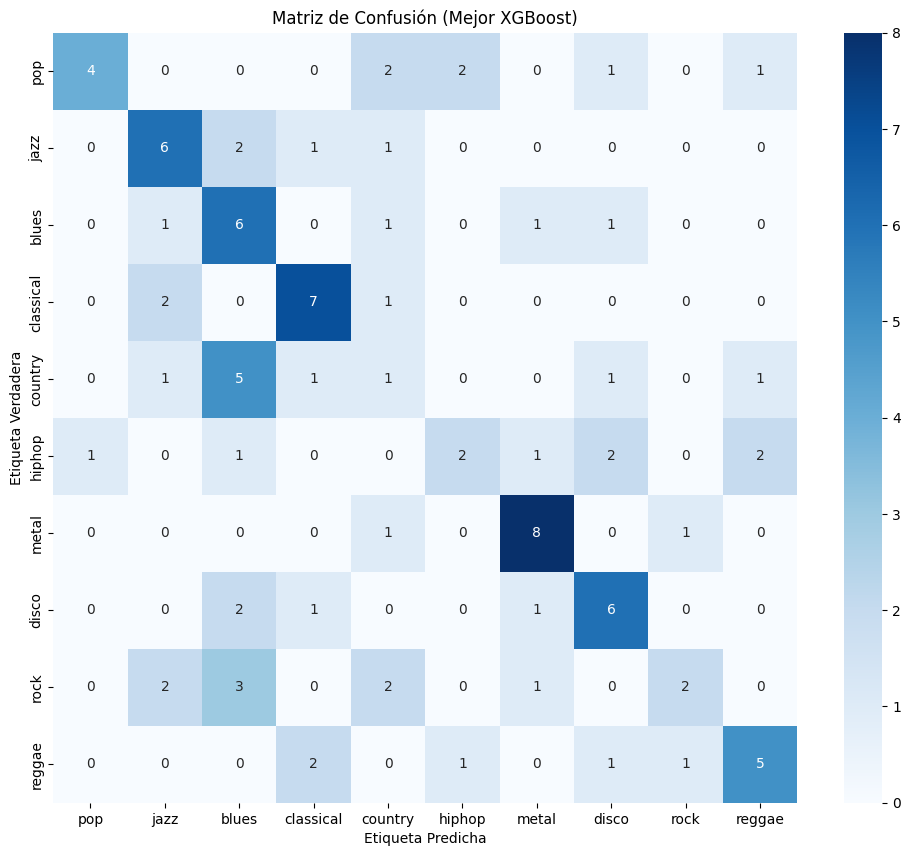


Entrenamiento completado!
Mejor pérdida de validación: 0.4400
El mejor clasificador se ha guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_XGBoostClassifier_SiLU.ckpt


In [59]:
# Cargar el mejor modelo del autoencoder
autoencoder = CELAutoencoderSiLU().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_SiLU.ckpt'
# Definir el espacio de hiperparámetros reducido
param_grid = {
    'max_depth': [7, 9],
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8]
}
train_and_evaluate_xgboost(autoencoder, checkpoint_path, param_grid, dataset, batch_size)

Extrayendo características latentes...


Extracting features:   0%|          | 0/50 [00:00<?, ?it/s]

Características extraídas: (990, 512)
Iniciando Grid Search para XGBoost...
Fitting 2 folds for each of 16 candidates, totalling 32 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:35:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Mejor exactitud en entrenamiento: 45.68%
Exactitud en Test (Mejor XGBoost): 49.49%
Reporte de Clasificación (Mejor XGBoost):
              precision    recall  f1-score   support

         pop       0.80      0.40      0.53        10
        jazz       0.50      0.50      0.50        10
       blues       0.33      0.40      0.36        10
   classical       0.70      0.70      0.70        10
     country       0.25      0.20      0.22        10
      hiphop       0.80      0.44      0.57         9
       metal       0.57      0.80      0.67        10
       disco       0.50      0.70      0.58        10
        rock       0.27      0.30      0.29        10
      reggae       0.50      0.50      0.50        10

    accuracy                           0.49        99
   macro avg       0.52      0.49      0.49        99
weighted avg       0.52      0.49      0.49        99



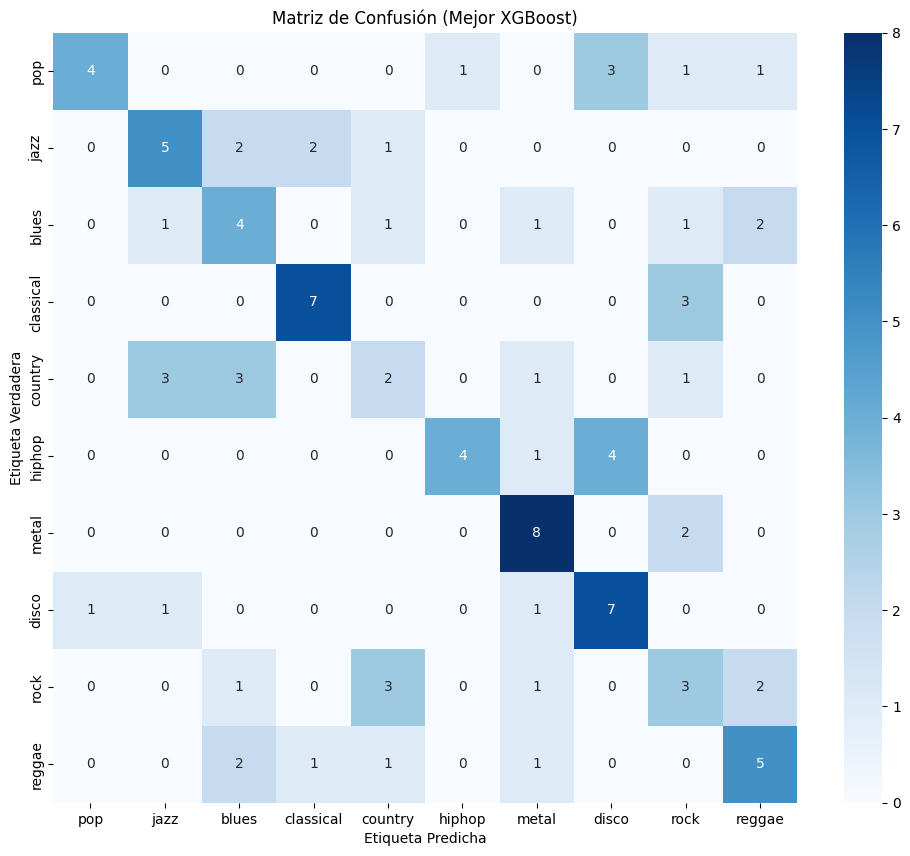


Entrenamiento completado!
Mejor pérdida de validación: 0.4568
El mejor clasificador se ha guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_XGBoostClassifier_CEL2.ckpt


In [60]:
# Cargar el mejor modelo del autoencoder
autoencoder = CELAutoencoder2().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_CEL2.ckpt'
# Definir el espacio de hiperparámetros reducido
param_grid = {
    'max_depth': [7, 9],
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8]
}
train_and_evaluate_xgboost(autoencoder, checkpoint_path, param_grid, dataset, batch_size)

Extrayendo características latentes...


Extracting features:   0%|          | 0/50 [00:00<?, ?it/s]

Características extraídas: (990, 256)
Iniciando Grid Search para XGBoost...
Fitting 2 folds for each of 16 candidates, totalling 32 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:49:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.6}
Mejor exactitud en entrenamiento: 50.62%
Exactitud en Test (Mejor XGBoost): 46.46%
Reporte de Clasificación (Mejor XGBoost):
              precision    recall  f1-score   support

         pop       0.67      0.60      0.63        10
        jazz       0.60      0.90      0.72        10
       blues       0.33      0.40      0.36        10
   classical       0.64      0.70      0.67        10
     country       0.14      0.10      0.12        10
      hiphop       0.50      0.44      0.47         9
       metal       0.50      0.60      0.55        10
       disco       0.44      0.40      0.42        10
        rock       0.00      0.00      0.00        10
      reggae       0.45      0.50      0.48        10

    accuracy                           0.46        99
   macro avg       0.43      0.46      0.44        99
weighted avg       0.43      0.46      0.44        99



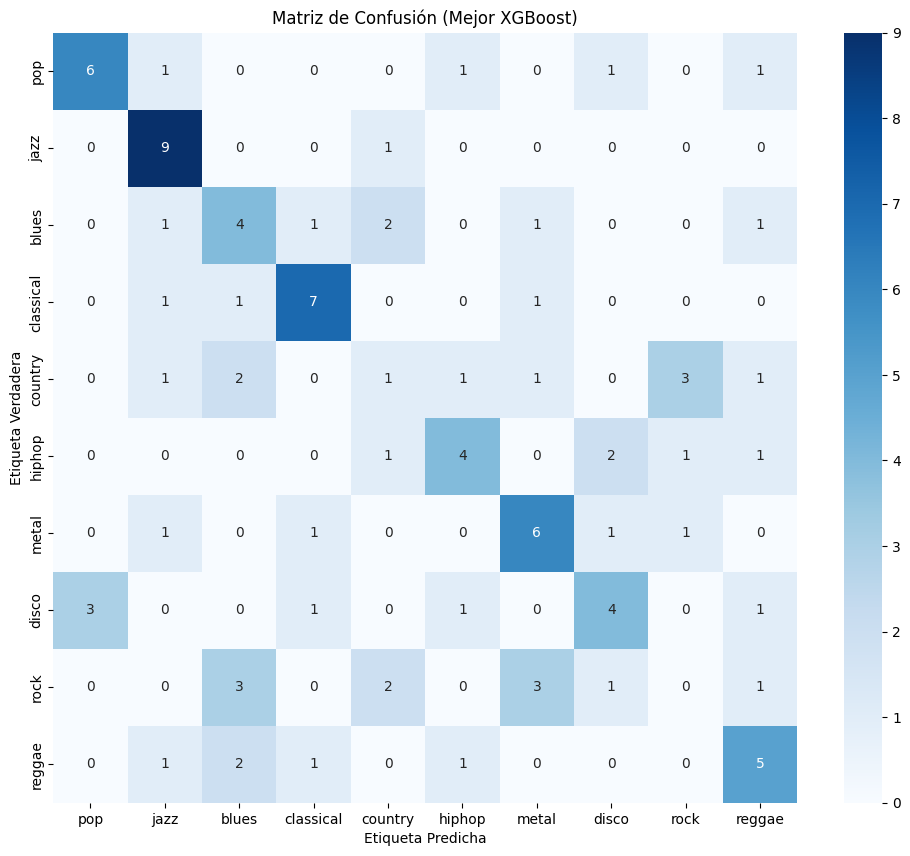


Entrenamiento completado!
Mejor pérdida de validación: 0.5062
El mejor clasificador se ha guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_XGBoostClassifier_CEL3.ckpt


In [61]:
# Cargar el mejor modelo del autoencoder
autoencoder = CELAutoencoder3().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_CEL3.ckpt'
# Definir el espacio de hiperparámetros reducido
param_grid = {
    'max_depth': [7, 9],
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8]
}
train_and_evaluate_xgboost(autoencoder, checkpoint_path, param_grid, dataset, batch_size)

##### **MusicGenreClassifier**

<ipython-input-6-f0cd1f0bc99b>:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(checkpoint_path))


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluación Final:
Pérdida de validación más baja: 1.2600
Exactitud en Validación: 55.00%

Reporte de Clasificación:
              precision    recall  f1-score   support

      reggae       0.43      0.86      0.57         7
       disco       0.62      0.38      0.48        13
   classical       0.83      0.94      0.88        16
     country       0.43      0.43      0.43         7
         pop       0.50      0.80      0.62         5
       blues       0.29      0.25      0.27         8
        rock       0.00      0.00      0.00        10
       metal       0.55      0.86      0.67         7
      hiphop       0.71      0.67      0.69        15
        jazz       0.40      0.33      0.36        12

    accuracy                           0.55       100
   macro avg       0.48      0.55      0.50       100
weighted avg       0.52      0.55      0.52       100



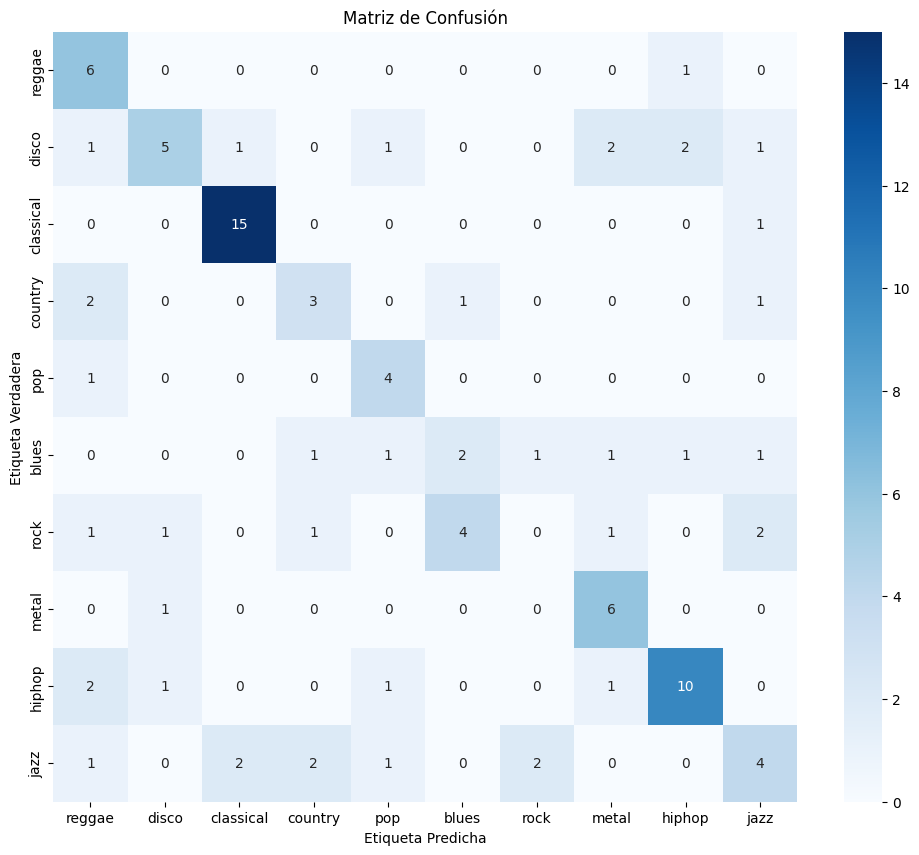

Modelo guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_classifier_LeakyRelu.ckpt


In [10]:
autoencoder = CELAutoencoderLR().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_LeakyRelu.ckpt'

train_music_genre_classifier(autoencoder, checkpoint_path, train_dl, valid_dl, dataset)

<ipython-input-6-f0cd1f0bc99b>:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(checkpoint_path))


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluación Final:
Pérdida de validación más baja: 1.2876
Exactitud en Validación: 51.00%

Reporte de Clasificación:
              precision    recall  f1-score   support

      reggae       0.50      0.57      0.53         7
       disco       0.55      0.46      0.50        13
   classical       0.65      0.94      0.77        16
     country       0.29      0.29      0.29         7
         pop       0.33      0.60      0.43         5
       blues       0.50      0.38      0.43         8
        rock       0.29      0.20      0.24        10
       metal       0.86      0.86      0.86         7
      hiphop       0.53      0.60      0.56        15
        jazz       0.20      0.08      0.12        12

    accuracy                           0.51       100
   macro avg       0.47      0.50      0.47       100
weighted avg       0.48      0.51      0.48       100



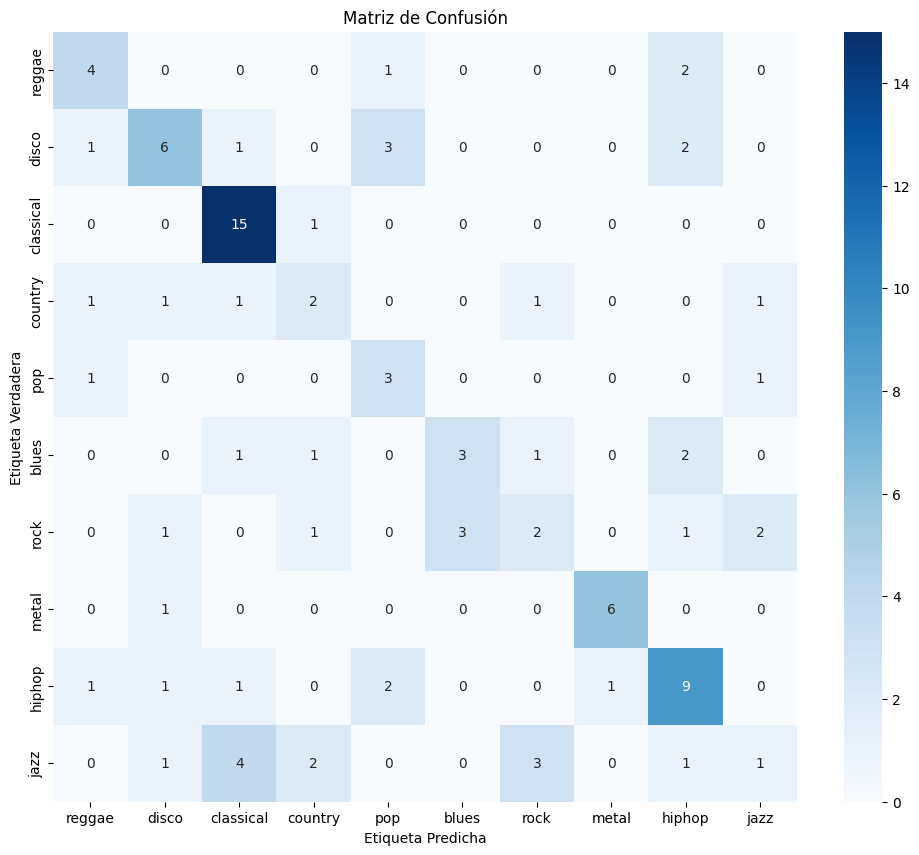

Modelo guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_classifier_SiLU.ckpt


In [11]:
autoencoder = CELAutoencoderSiLU().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_SiLU.ckpt'

train_music_genre_classifier(autoencoder, checkpoint_path, train_dl, valid_dl, dataset)

<ipython-input-6-f0cd1f0bc99b>:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(checkpoint_path))


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluación Final:
Pérdida de validación más baja: 1.2721
Exactitud en Validación: 54.00%

Reporte de Clasificación:
              precision    recall  f1-score   support

      reggae       0.46      0.86      0.60         7
       disco       0.71      0.38      0.50        13
   classical       0.70      0.88      0.78        16
     country       0.33      0.43      0.38         7
         pop       0.38      0.60      0.46         5
       blues       0.33      0.38      0.35         8
        rock       0.00      0.00      0.00        10
       metal       0.58      1.00      0.74         7
      hiphop       0.67      0.67      0.67        15
        jazz       0.50      0.25      0.33        12

    accuracy                           0.54       100
   macro avg       0.47      0.54      0.48       100
weighted avg       0.51      0.54      0.50       100



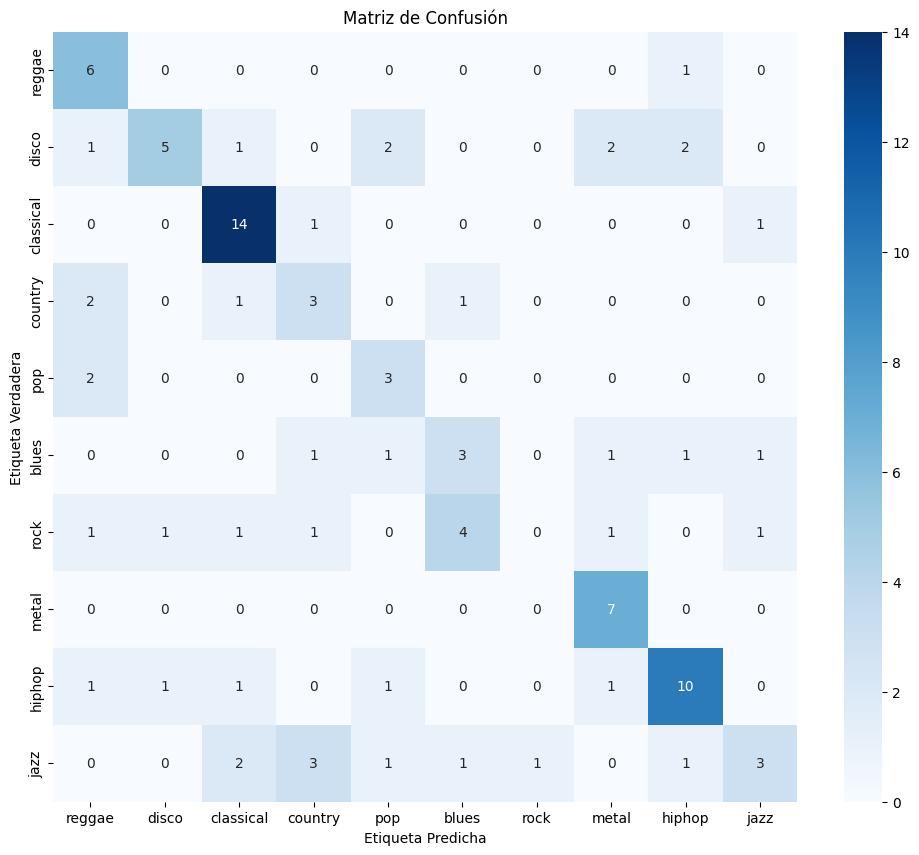

Modelo guardado en: /content/drive/MyDrive/TDVI_TP4/best_classifiers/best_classifier_CEL2.ckpt


In [12]:
autoencoder = CELAutoencoder2().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_CEL2.ckpt'

train_music_genre_classifier(autoencoder, checkpoint_path, train_dl, valid_dl, dataset)

In [13]:
autoencoder = CELAutoencoder3().to(device)
checkpoint_path = '/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_CEL3.ckpt'

train_music_genre_classifier(autoencoder, checkpoint_path, train_dl, valid_dl, dataset)

<ipython-input-6-f0cd1f0bc99b>:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(checkpoint_path))


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x256 and 512x256)

#### **PCA**

Extrayendo características latentes y etiquetas...


Extracting features:   0%|          | 0/50 [00:00<?, ?it/s]

Características extraídas: (990, 512)
Características reducidas con PCA: (990, 2)


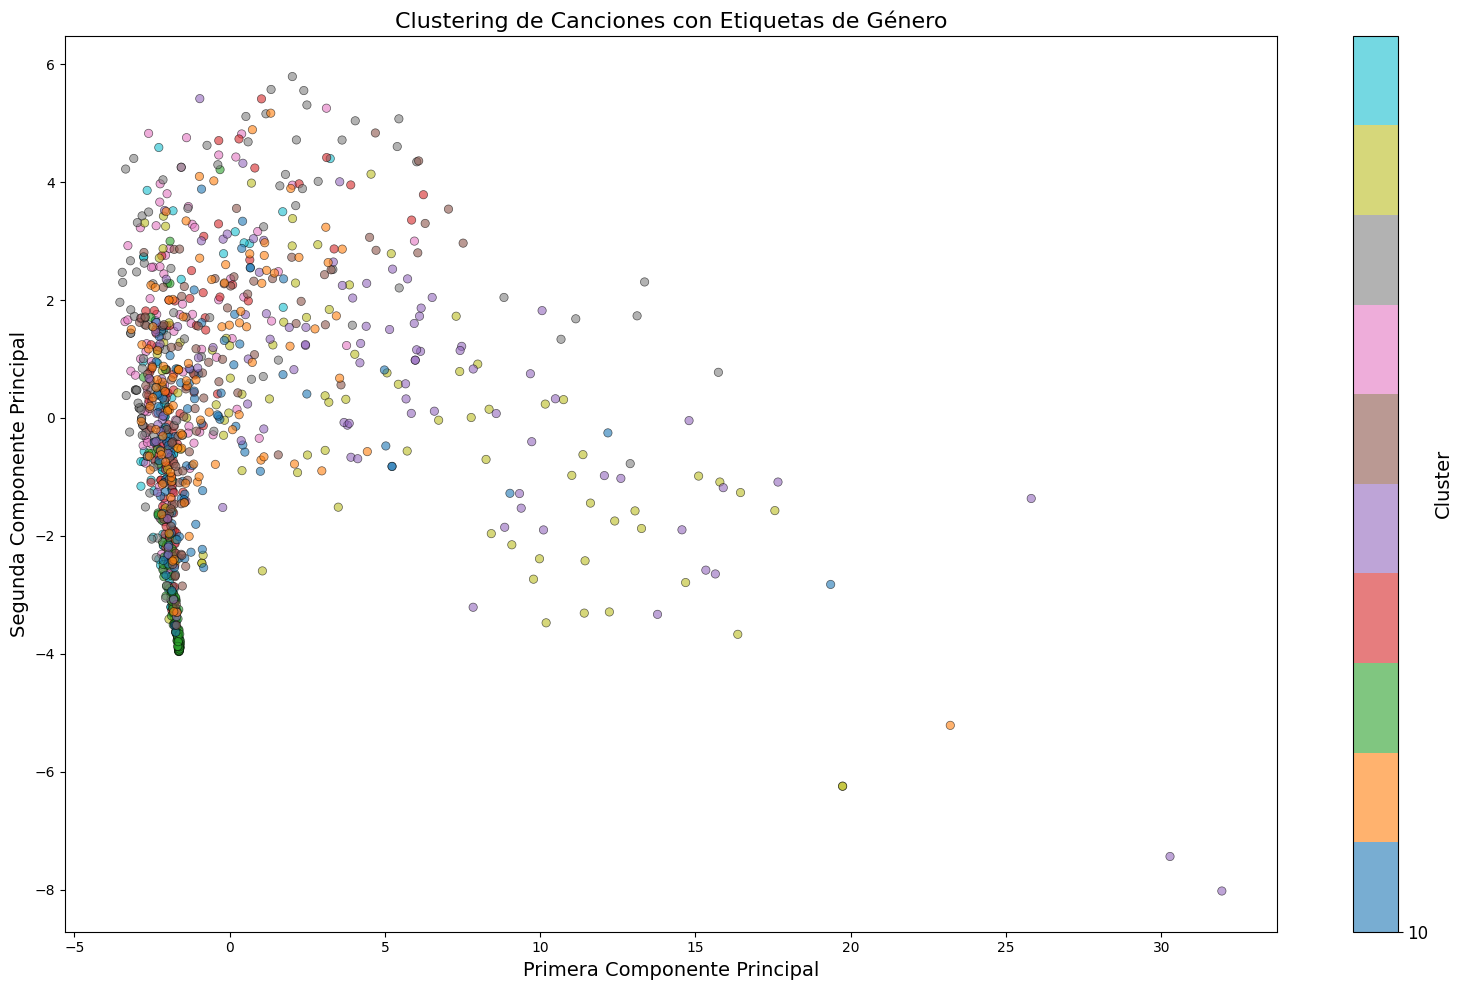

In [24]:
# Cargar el mejor modelo del autoencoder
autoencoder = CELAutoencoderSiLU().to(device)
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/TDVI_TP4/best_autoencoders/best_autoencoder_SiLU.ckpt', weights_only=True))
autoencoder.eval()

# Crear un DataLoader sin shuffle para extracción de características
feature_dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
n_clusters = len(dataset.classes)

# Extraer características y etiquetas
print("Extrayendo características latentes y etiquetas...")
features, labels, genres = get_encoded_features(autoencoder, feature_dl, device)
print(f"Características extraídas: {features.shape}")

# Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
print(f"Características reducidas con PCA: {features_2d.shape}")

plot_clustering_results(
    features_2d=features_2d,
    labels=labels,
    clusters=n_clusters,
    title='Clustering de Canciones con Etiquetas de Género'
)


##### **K-means**

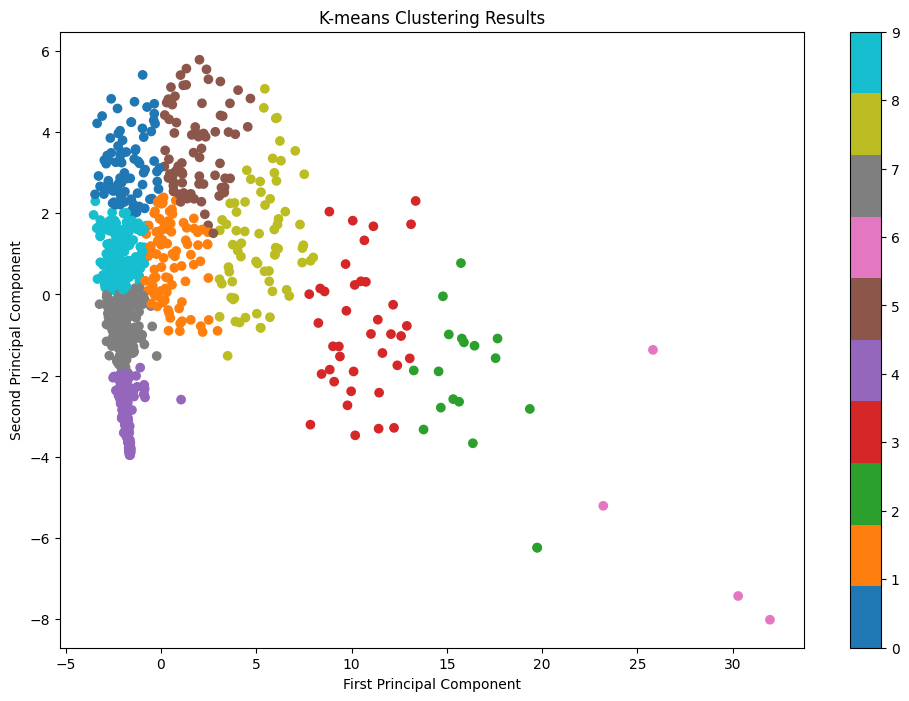


Clustering Metrics:
Adjusted Rand Index: 0.076
Adjusted Mutual Information: 0.130


In [19]:
# Realizar clustering con K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
clusters_kmeans = kmeans.fit_predict(features_2d)

# Compare clustering with true labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters_kmeans, cmap='tab10')
plt.colorbar(scatter)
plt.title('K-means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print("\nClustering Metrics:")
print(f"Adjusted Rand Index: {adjusted_rand_score(labels, clusters_kmeans):.3f}")
print(f"Adjusted Mutual Information: {adjusted_mutual_info_score(labels, clusters_kmeans):.3f}")



##### **Gaussian Mixture**

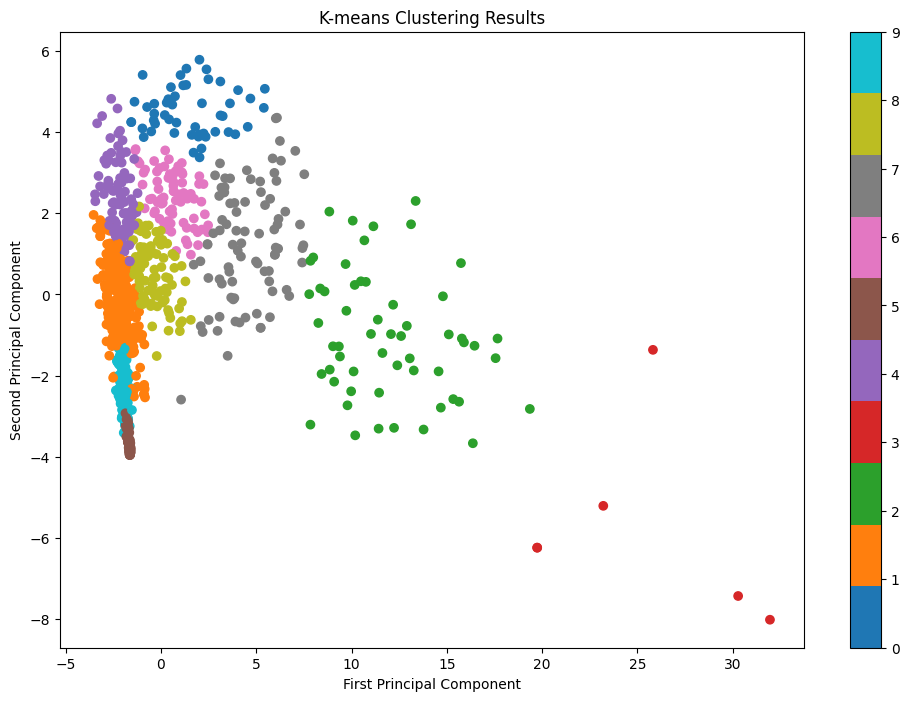


Clustering Metrics:
Adjusted Rand Index: 0.068
Adjusted Mutual Information: 0.147


In [20]:
# Inicializar y ajustar el modelo GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=random_state, n_init=10)
clusters_gmm = gmm.fit_predict(features_2d)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters_gmm, cmap='tab10')
plt.colorbar(scatter)
plt.title('K-means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print("\nClustering Metrics:")
print(f"Adjusted Rand Index: {adjusted_rand_score(labels, clusters_gmm):.3f}")
print(f"Adjusted Mutual Information: {adjusted_mutual_info_score(labels, clusters_gmm):.3f}")


##### **Hierarchical Clustering**

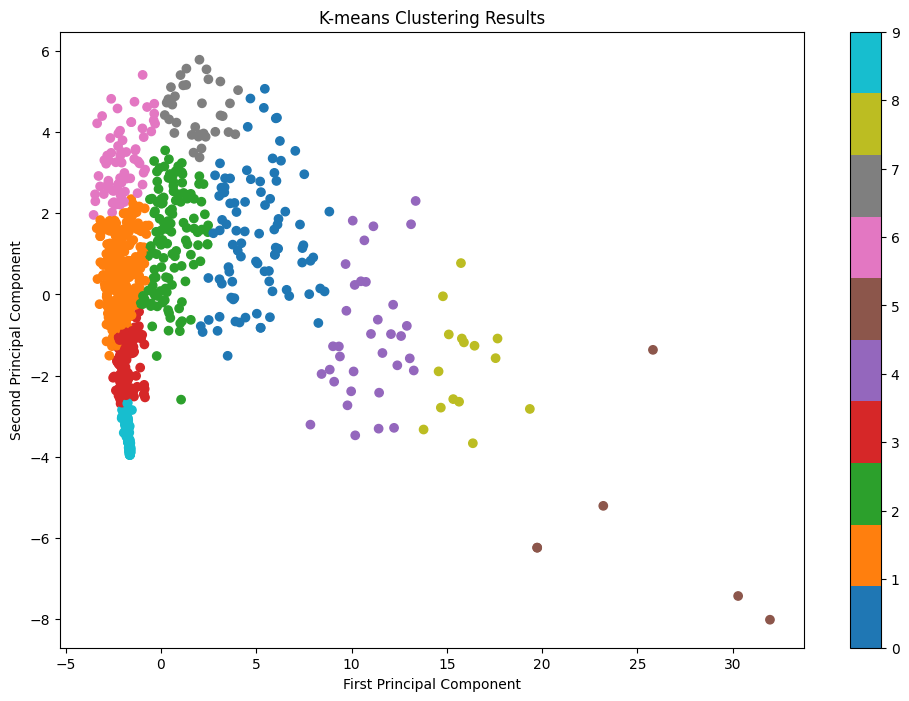


Métricas de Clustering:
Índice Rand Ajustado (ARI): 0.068
Información Mutua Ajustada (AMI): 0.150


In [21]:
# Inicializar y ajustar el modelo de Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(features_2d)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters_hierarchical, cmap='tab10')
plt.colorbar(scatter)
plt.title('K-means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Calcular métricas de clustering
ari = adjusted_rand_score(labels, clusters_hierarchical)
ami = adjusted_mutual_info_score(labels, clusters_hierarchical)
print("\nMétricas de Clustering:")
print(f"Índice Rand Ajustado (ARI): {ari:.3f}")
print(f"Información Mutua Ajustada (AMI): {ami:.3f}")